In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import soundfile as sf
from collections import defaultdict
from python_speech_features import logfbank,mfcc
from utils import *
import numpy as np
from sklearn.manifold import TSNE
from CQCC.cqcc import cqcc

In [2]:
label_train_path="../Data/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
label_dev_path="../Data/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
label_eval_path="../Data/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
data_train_path="../Data/LA/ASVspoof2019_LA_train/flac/"
data_dev_path="../Data/LA/ASVspoof2019_LA_dev/flac"
data_eval_path="../Data/LA/ASVspoof2019_LA_eval/flac"
train_path="../Data/LA_CSV/train_data.csv"
dev_path="../Data/LA_CSV/dev_data.csv"
test_path="../Data/LA_CSV/test_data.csv"

In [3]:
total_train_files = len(os.listdir(data_train_path))
total_dev_files = len(os.listdir(data_dev_path))
total_eval_files = len(os.listdir(data_eval_path))
print("total_train_files : ",total_train_files)
print("total_dev_files : ",total_dev_files)
print("total_eval_files : ",total_eval_files)

total_train_files :  25379
total_dev_files :  24986
total_eval_files :  71933


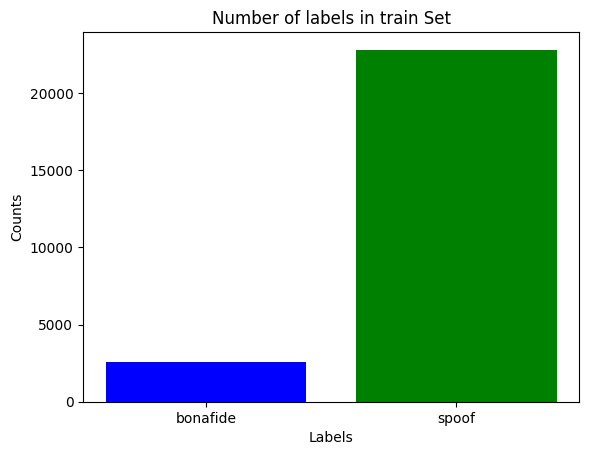

In [4]:
plot_label_counts(label_train_path,"Number of labels in train Set")

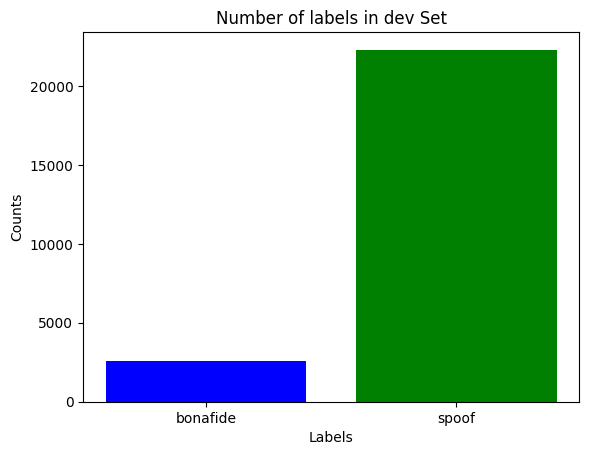

In [5]:
plot_label_counts(label_dev_path,"Number of labels in dev Set")

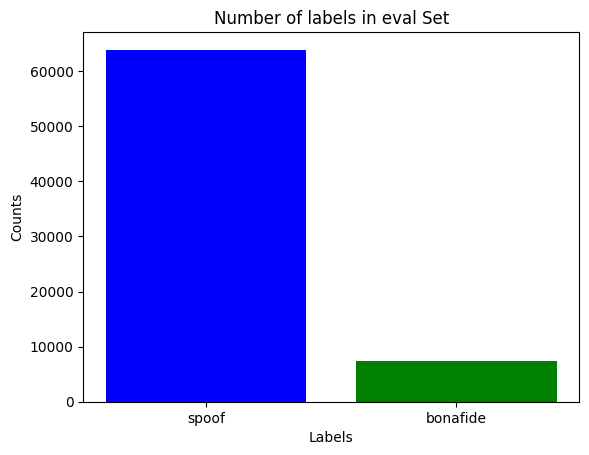

In [6]:
plot_label_counts(label_eval_path,"Number of labels in eval Set")

In [7]:
#train_data=create_audio_dataset(data_train_path,label_train_path,log=True)
train_data=pd.read_csv(train_path)
if 'Unnamed: 0' in train_data.columns:
    train_data.drop(columns=['Unnamed: 0'], inplace=True)
train_data.head()

,FileName,Label,Length
0,LA_T_1000137,spoof,2.500375
1,LA_T_1000406,bonafide,2.850500
2,LA_T_1000648,spoof,1.922063
3,LA_T_1000824,spoof,2.271625
4,LA_T_1001074,spoof,3.764562


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25379 entries, 0 to 25378
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  25379 non-null  object 
 1   Label     25379 non-null  object 
 2   Length    25379 non-null  float64
dtypes: float64(1), object(2)
memory usage: 594.9+ KB


In [9]:
train_data.describe()

,Length
count,25379.000000
mean,3.425849
std,1.418898
min,0.652438
25%,2.434563
50%,3.201687
75%,4.109594
max,13.187938


In [10]:
#dev_data=create_audio_dataset(data_dev_path,label_dev_path,log=True)
dev_data=pd.read_csv(dev_path)
if 'Unnamed: 0' in dev_data.columns:
    dev_data.drop(columns=['Unnamed: 0'], inplace=True)
dev_data.head()

,FileName,Label,Length
0,LA_D_1000265,spoof,1.468000
1,LA_D_1000752,spoof,2.471312
2,LA_D_1001095,spoof,3.917063
3,LA_D_1002130,spoof,3.926563
4,LA_D_1002200,spoof,4.473562


In [11]:
classes=["spoof","bonafide"]

**Spoofed Speech**

In [12]:
sig_spoof,rate=sf.read(data_train_path+train_data[train_data.Label=="spoof"].iloc[0,0]+'.flac')
ipd.Audio(sig_spoof,rate=rate)

**Bonafide Audio**

In [13]:
sig_spoof,rate=sf.read(data_train_path+train_data[train_data.Label=="bonafide"].iloc[0,0]+'.flac')
ipd.Audio(sig_spoof,rate=rate)

In [14]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)  # Fix: Use `suptitle` instead of `subtitle`
    i = 0
    for y in range(2):
        axes[y].set_title(list(signals.keys())[i])
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)  # Fix: `set_visible`, not `set_visibel`
        i += 1
            
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform', size=16)  # Fix: Use `suptitle` instead of `subtitle`
    i = 0
    for x in range(1):
        for y in range(2):
            data = list(fft.values())[i]  # Fix: Use `list(fft.values())[i]`
            Y, freq = data[0], data[1]
            axes[y].set_title(list(fft.keys())[i])
            axes[y].plot(freq, Y)
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)  # Fix: `set_visible`, not `set_visibel`
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)  # Fix: Use `suptitle` instead of `subtitle`
    i = 0
    for y in range(2):
        axes[y].set_title(list(mfccs.keys())[i])
        axes[y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)  # Fix: `set_visible`, not `set_visibel`
        i += 1
    

In [15]:
def envelope(y,rate,threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)  
    return mask

In [16]:
def calc_fft(y,rate):
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/rate)
    Y=np.abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [17]:
def extract_cqcc(x, fs):
    # INPUT SIGNAL
    x = x.reshape(x.shape[0], 1)  # for one-channel signal
    # PARAMETERS
    B = 96
    fmax = fs / 2
    fmin = fmax / 2 ** 9
    d = 16
    cf = 19
    ZsdD = 'ZsdD'
    # COMPUTE CQCC FEATURES
    CQcc, LogP_absCQT, TimeVec, FreqVec, Ures_LogP_absCQT, Ures_FreqVec, absCQT = cqcc(x, fs, B, fmax, fmin, d, cf,
                                                                                       ZsdD)
    return CQcc, fmax, fmin

[-0.00054932 -0.00061035 -0.00061035 ... -0.09463501 -0.08956909
 -0.10101318]
start of the signal :  3.11767578125e-05
end of the signal :  nan


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\HP\AppData\Local\Temp\ipykernel_14312\3933098253.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\HP\AppData\Local\Temp\ipykernel_14312\3933098253.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


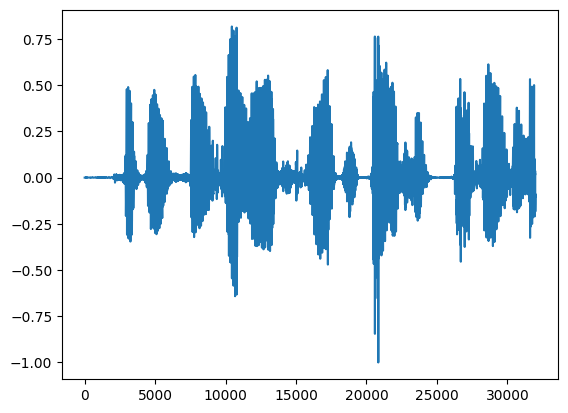

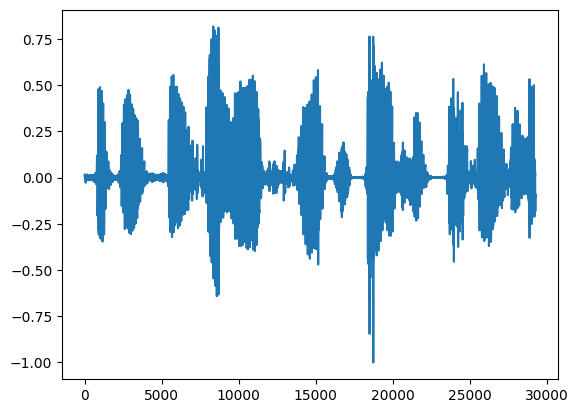

In [30]:
for c in classes:
    audio_file=train_data[train_data.Label==c].iloc[0,0]
    signal,rate=sf.read(data_train_path+audio_file+'.flac')
    signal=signal[:2*rate]
    print(signal)
    print("start of the signal : ",np.mean(signal[:2500]))
    print("end of the signal : ",np.mean(signal[35000:]))
    mask=envelope(signal,rate,0.005)
    signal_masked=signal[mask]
    f=plt.figure(1)
    plt.plot(signal)
    f.show()
    g=plt.figure(2)
    plt.plot(signal_masked)
    g.show()
    break  

In [19]:
ipd.Audio(signal,rate=rate)

In [20]:
ipd.Audio(signal_masked,rate=rate)

In [21]:
signals={}
fft={}
fbank={}
mfccs={}
cqccs={}
for c in classes:
    audio_file=train_data[train_data.Label==c].iloc[0,0]
    signal,rate=sf.read(data_train_path+audio_file+'.flac')
    mask=envelope(signal,rate,0.0005)
    signal=signal[mask]
    #signals and fft
    signals[c]=signal
    fft[c]=calc_fft(signal,rate)
    #bank
    bank=logfbank(signal[:2*rate],rate,nfilt=26,nfft=400).T
    fbank[c]=bank
    #mfccs
    mel=mfcc(signal[:2*rate],rate,numcep=13,nfilt=26,nfft=800).T
    mfccs[c]=mel
    ##cqcc
    feat_cqcc, _, _ = extract_cqcc(signal[:2*rate], rate)
    cqccs[c]=feat_cqcc

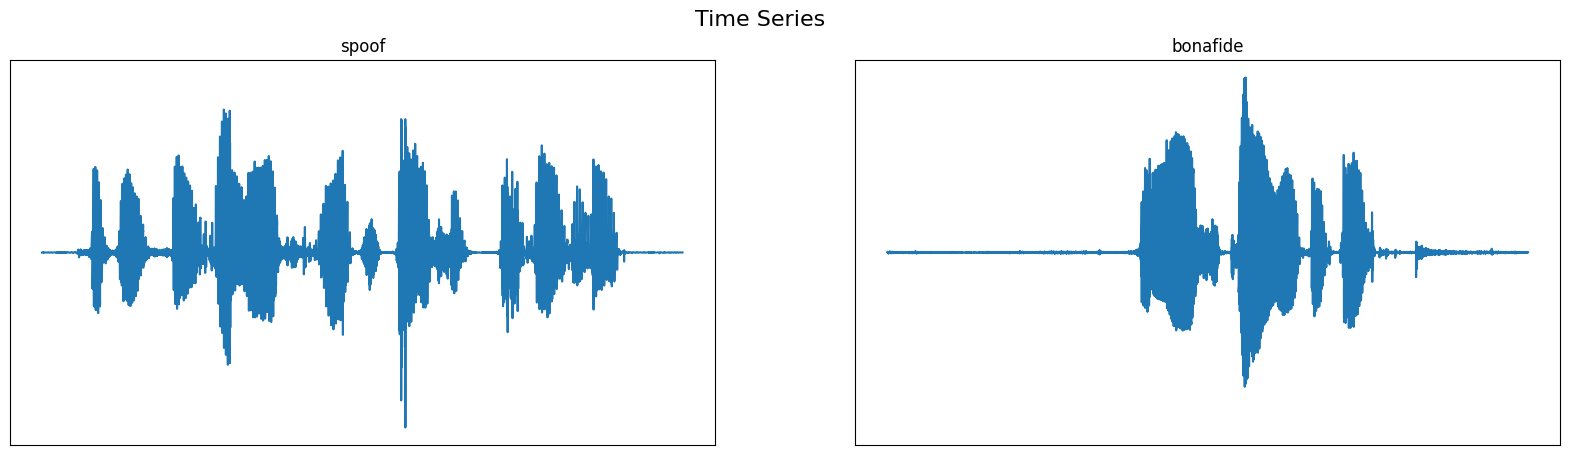

In [22]:
plot_signals(signals)

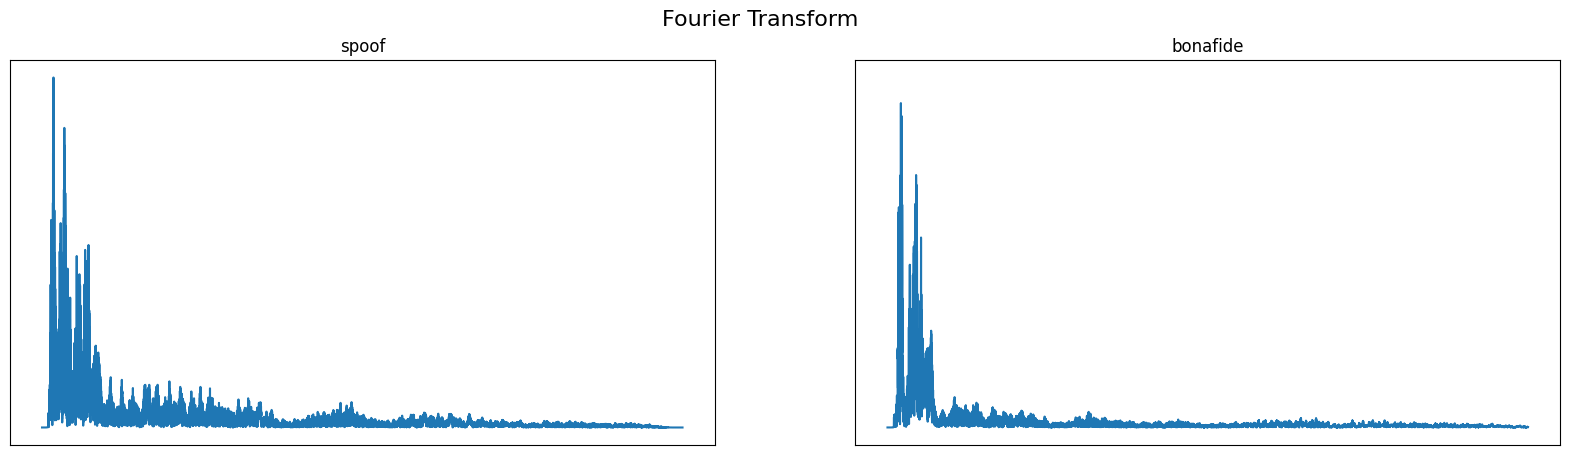

In [23]:
plot_fft(fft)

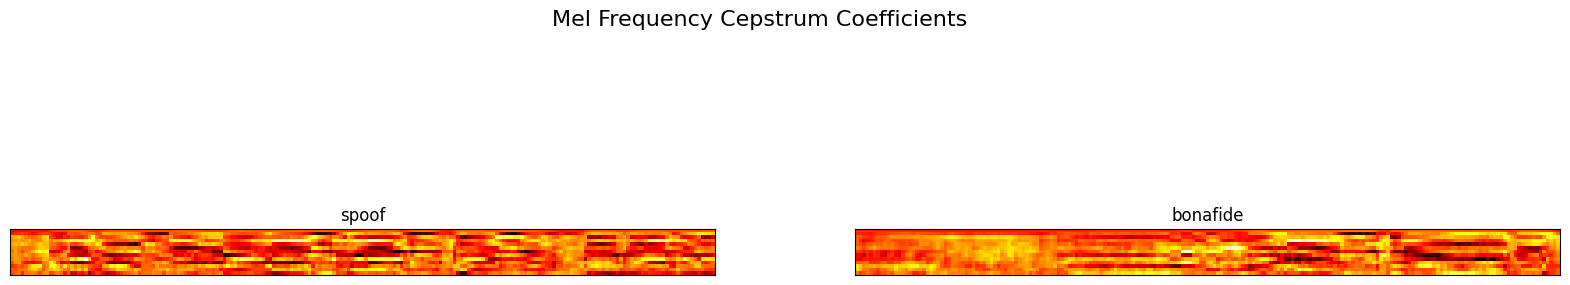

In [24]:
plot_mfccs(mfccs)

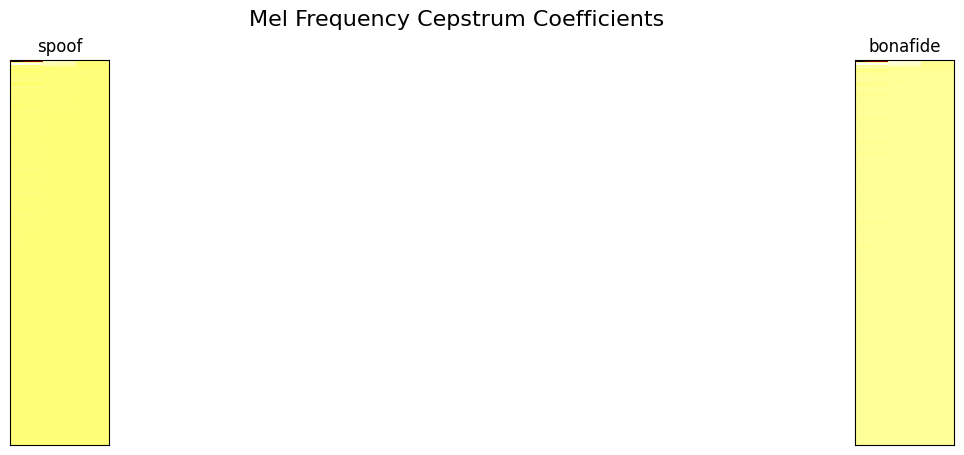

In [25]:
plot_mfccs(cqccs)

In [26]:
mfccs['spoof']

array([[-1.29178792e+01, -1.31413660e+01, -1.32371911e+01, ...,
        -1.27670446e+00, -1.00345402e+00, -1.52253094e+00],
       [-1.24038322e+01, -9.60774120e+00, -8.84635581e+00, ...,
         1.78724364e+01,  1.66955104e+01,  1.48333082e+01],
       [ 7.66512436e+00,  1.09139004e+01,  1.42149247e+01, ...,
        -3.13354605e+01, -3.04286796e+01, -2.18474596e+01],
       ...,
       [-8.17703687e+00, -6.37670639e+00, -7.49419136e-01, ...,
        -1.99008352e-01, -1.31549111e-01, -5.33696986e-03],
       [-2.94852173e+00, -3.45219165e+00,  9.68517122e-01, ...,
        -6.91142296e+00, -7.46260686e+00, -7.44441825e+00],
       [-4.25315682e+00, -6.62761433e-01,  2.37591689e+00, ...,
        -2.64229390e+01, -2.46844485e+01, -1.99310766e+01]])

In [27]:
def get_tsne_embeddings(features, perplexity, iteration,n_components=2):
    embedding = TSNE(n_components=n_components,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)

    return embedding
perplexity = 50
iteration = 5000
feats_spoof=get_tsne_embeddings(mfccs["spoof"].T,perplexity=perplexity,iteration=iteration)
feats_bonafide=get_tsne_embeddings(mfccs["bonafide"].T,perplexity=perplexity,iteration=iteration)

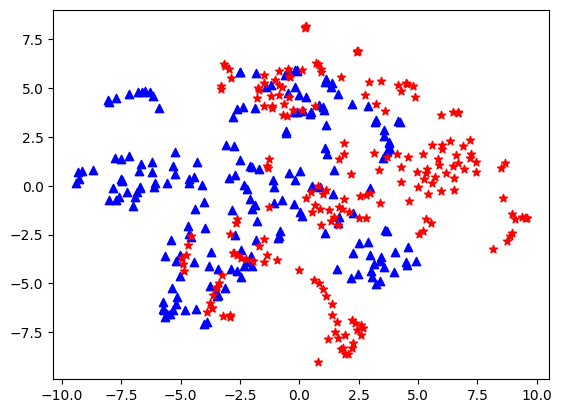

In [28]:
plt.scatter(feats_spoof[:,0], feats_spoof[:,1], marker='^', color='blue',label="spoof")
plt.scatter(feats_bonafide[:,0], feats_bonafide[:,1], marker='*', color='red',label="bonafide")


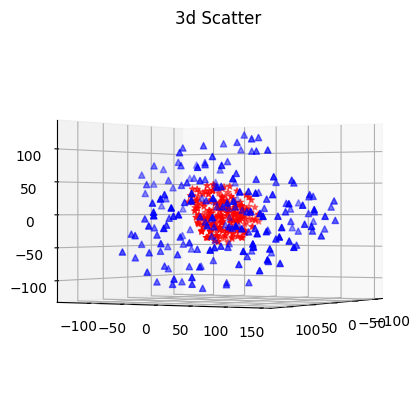

In [29]:
feats_spoof=get_tsne_embeddings(mfccs["spoof"].T,perplexity=perplexity,iteration=iteration,
                                n_components=3)
feats_bonafide=get_tsne_embeddings(mfccs["bonafide"].T,perplexity=perplexity,iteration=iteration,n_components=3)
ax = plt.axes(projection='3d')
ax.scatter(feats_spoof[:,0],feats_spoof[:,1],feats_spoof[:,2],marker='^', color='blue',label="spoof")
ax.scatter(feats_bonafide[:,0],feats_bonafide[:,1],feats_bonafide[:,2],marker='*', color='red',label="bonafide")
ax.set_title('3d Scatter')
ax.view_init(0, 30)
plt.draw()
plt.show()